In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_predict

In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')

word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')

word2vec_selftrain_train_data = pd.read_csv('../Data/TrainingData/word2vec_selftrain_train.csv')
word2vec_selftrain_val_data = pd.read_csv('../Data/ValidateData/word2vec_selftrain_val.csv')

bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

bert_selftrain_train_data = pd.read_csv('../Data/TrainingData/bert_selftrain_train.csv')
bert_selftrain_val_data = pd.read_csv('../Data/ValidateData/bert_selftrain_val.csv')

In [3]:
def train_lr_model(train_df, val_df):
  train_data = train_df.copy()
  val_data = val_df.copy()
  
  y_train = train_data.pop('source')  # 假設標籤列名為 'source'
  y_val = val_data.pop('source')  # 假設標籤列名為 'source'

  # 標準化數據
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(train_data.values)
  X_val_scaled = scaler.transform(val_data.values)

# 10折交叉驗證
  kf = KFold(n_splits=10, shuffle=True, random_state=42)
  fold = 0
  confusion_matrices = []
  f2_scores = []
  best_model = None
  best_f2_score = float('-inf')

  for train_index, test_index in kf.split(X_train_scaled):
    fold += 1
    X_train, X_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # 建立Logistic Regression模型
    model = LogisticRegression(max_iter=1000, solver='liblinear')

    # 訓練模型
    model.fit(X_train, y_train_fold)

    # 測試模型並計算F2 score
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    cm_train = confusion_matrix(y_train_fold, y_pred_train)
    cm_test = confusion_matrix(y_test_fold, y_pred_test)
    confusion_matrices.append((cm_train, cm_test))

    f2 = fbeta_score(y_test_fold, y_pred_test, beta=2)
    f2_scores.append(f2)

    # 保存最佳模型
    if f2 > best_f2_score:
      best_f2_score = f2
      best_model = model

  # 計算平均F2-score
  avg_f2_score = sum(f2_scores) / len(f2_scores)
  print(f'Average F2 Score: {avg_f2_score:.4f}')

  # 計算混淆矩陣加總再標準化
  sum_cm_train = sum([cm[0] for cm in confusion_matrices])
  sum_cm_test = sum([cm[1] for cm in confusion_matrices])

  norm_cm_train = sum_cm_train.astype('float') / sum_cm_train.sum(axis=1)[:, np.newaxis]
  norm_cm_test = sum_cm_test.astype('float') / sum_cm_test.sum(axis=1)[:, np.newaxis]

  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  fig.suptitle('Normalized Confusion Matrices')

  sns.heatmap(norm_cm_train, annot=True, fmt='.2f', ax=axs[0], cmap='Blues')
  axs[0].set_title('Normalized Train Confusion Matrix')
  axs[0].set_xlabel('Predicted')
  axs[0].set_ylabel('Actual')

  sns.heatmap(norm_cm_test, annot=True, fmt='.2f', ax=axs[1], cmap='Blues')
  axs[1].set_title('Normalized Test Confusion Matrix')
  axs[1].set_xlabel('Predicted')
  axs[1].set_ylabel('Actual')

  plt.tight_layout()
  plt.subplots_adjust(top=0.88)
  plt.show()

  # 評估validation set
  y_val_pred = best_model.predict(X_val_scaled)
  val_cm = confusion_matrix(y_val, y_val_pred)
  val_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

  print(f'Validation F2 Score: {val_f2_score:.4f}')

  norm_val_cm = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize=(7, 5))
  sns.heatmap(norm_val_cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title('Normalized Validation Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

Average F2 Score: 0.9930


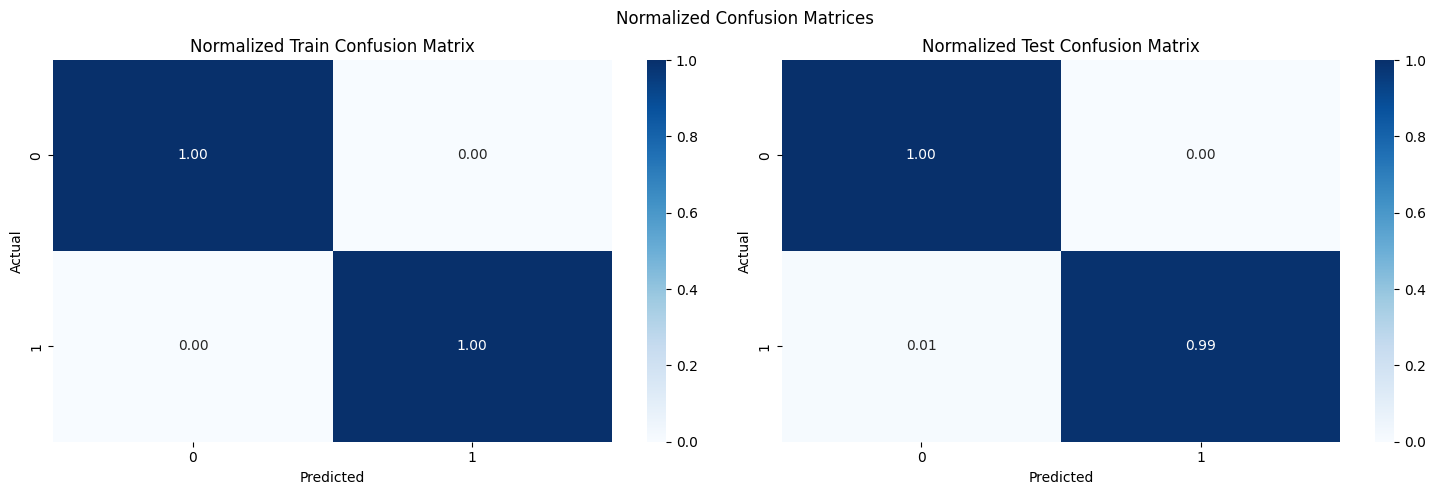

Validation F2 Score: 0.9961


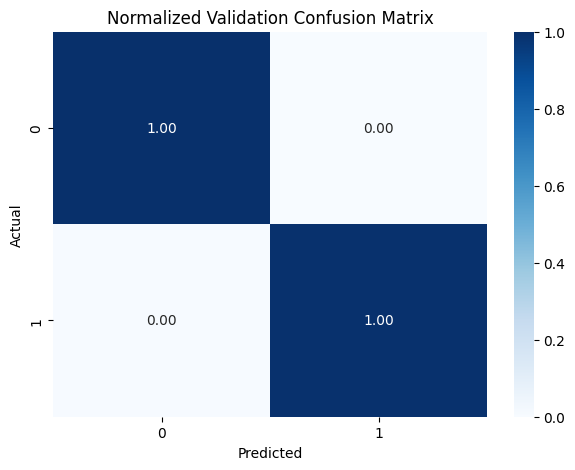

In [4]:
train_lr_model(tfidf_train_data, tfidf_val_data)

Average F2 Score: 0.9966


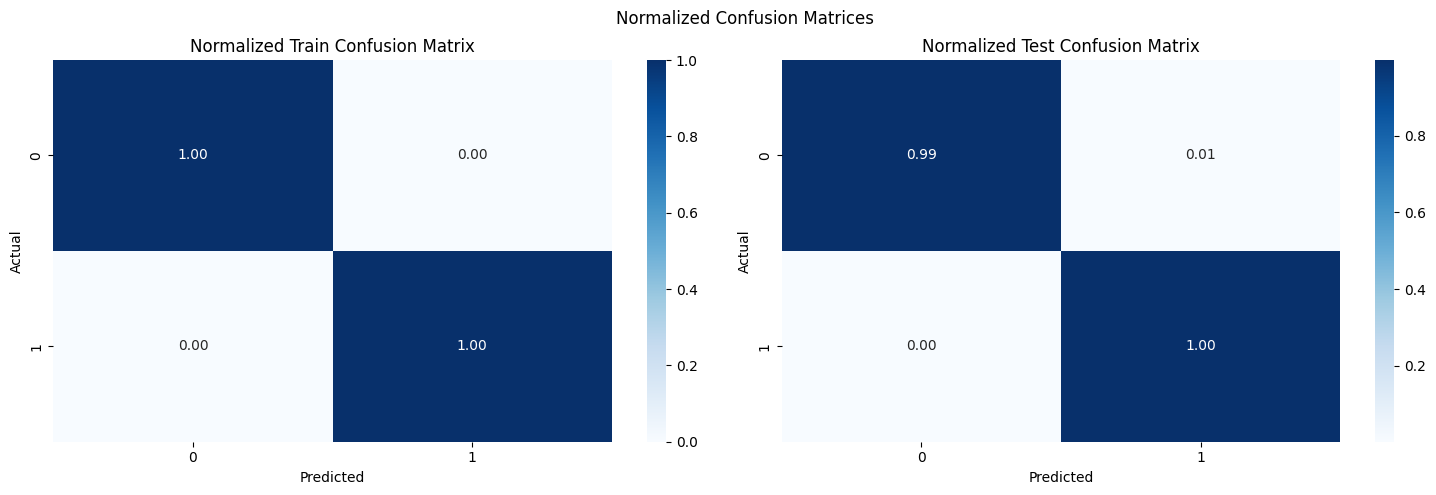

Validation F2 Score: 0.9932


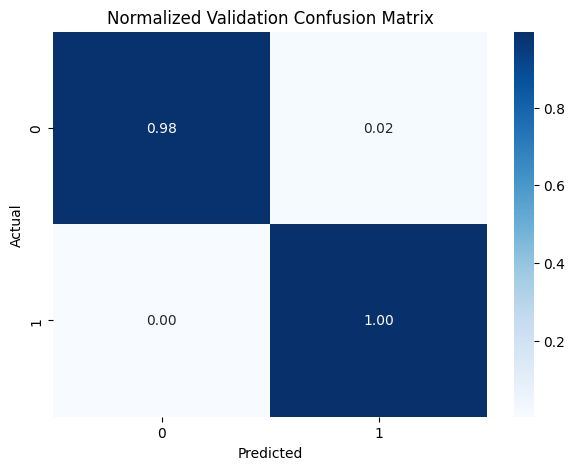

In [5]:
train_lr_model(word2vec_selftrain_train_data, word2vec_selftrain_val_data)

Average F2 Score: 0.9924


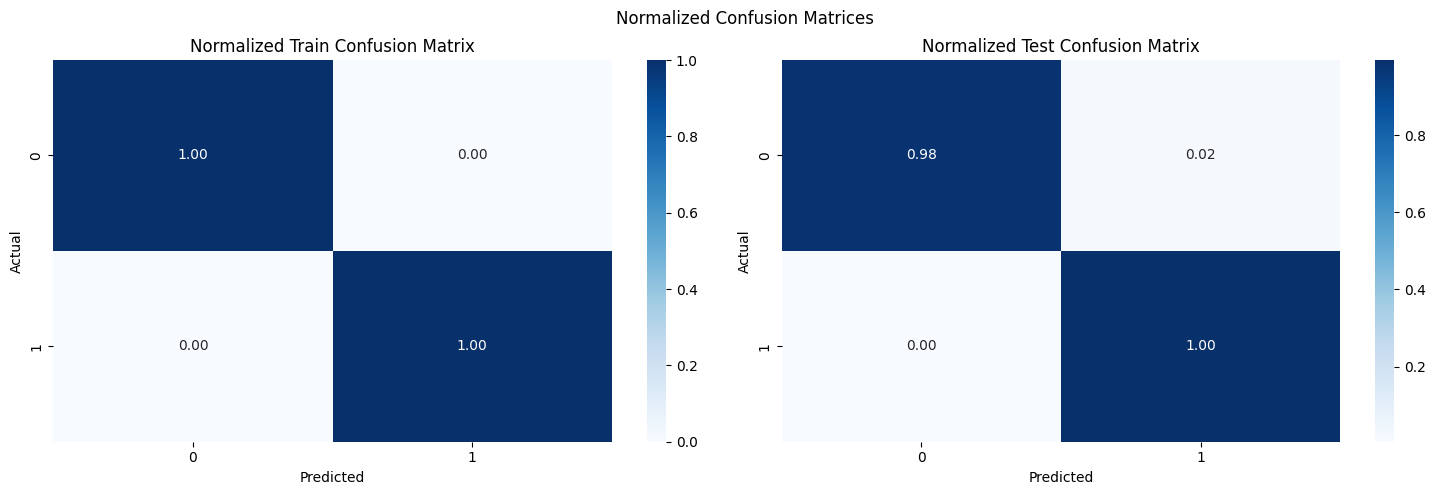

Validation F2 Score: 0.9834


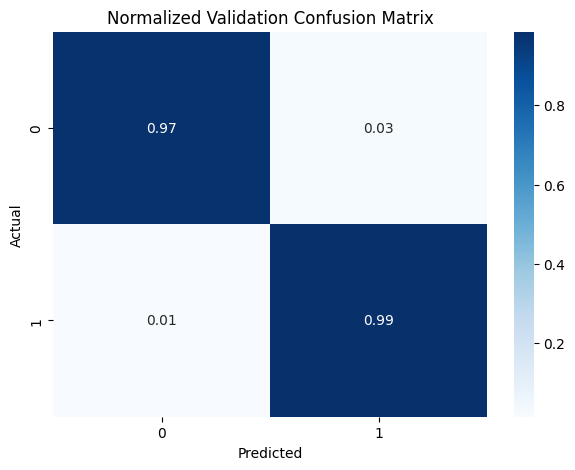

In [6]:
train_lr_model(word2vec_train_data, word2vec_val_data)

Average F2 Score: 0.9975


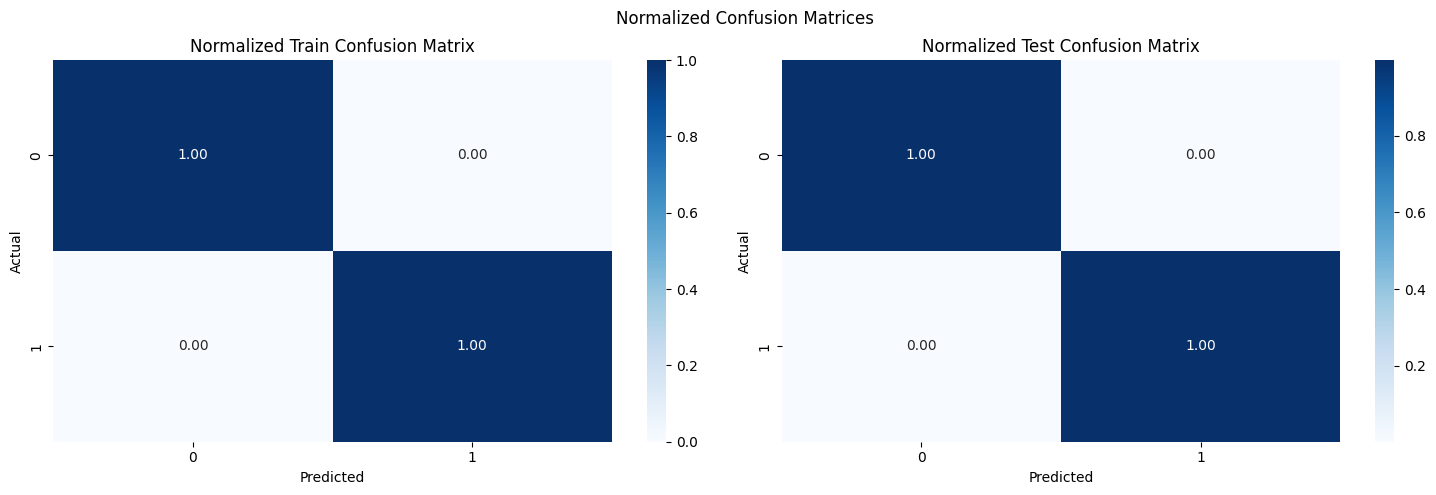

Validation F2 Score: 0.9961


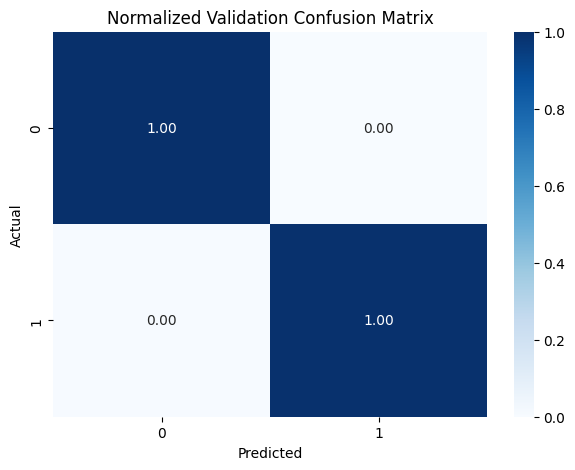

In [7]:
train_lr_model(bert_selftrain_train_data, bert_selftrain_val_data)

Average F2 Score: 0.9975


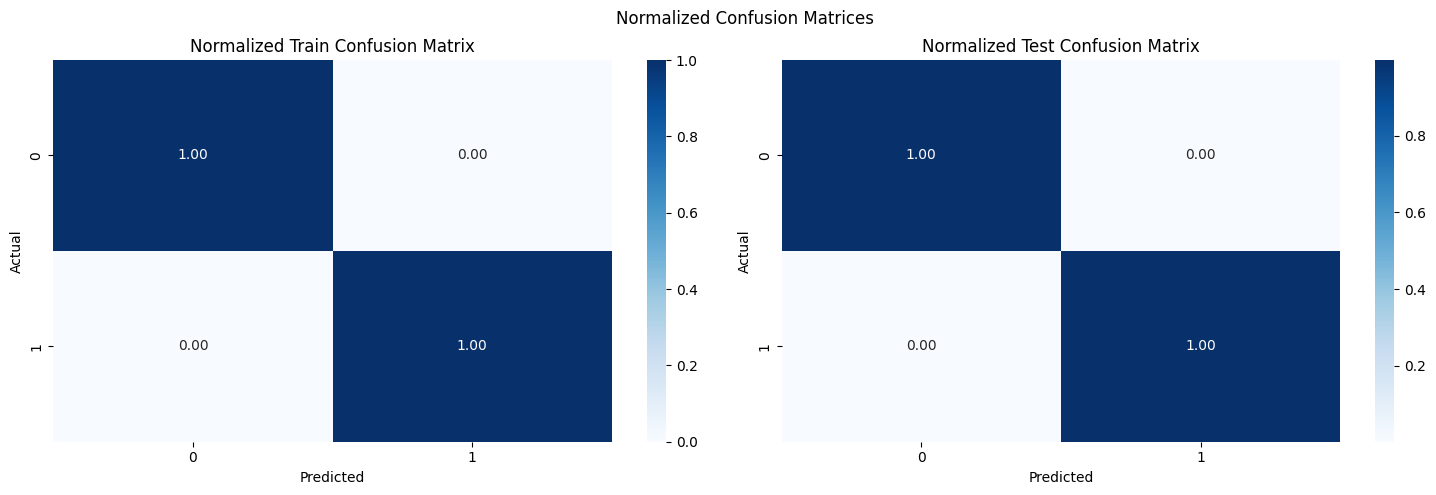

Validation F2 Score: 0.9961


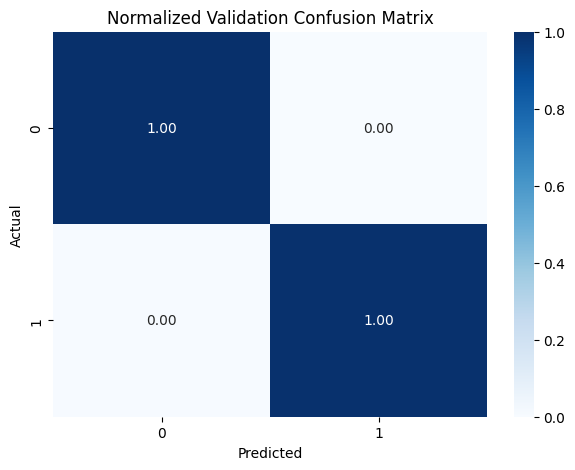

In [8]:
train_lr_model(bert_train_data, bert_val_data)